In [109]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

## Load data

In [ ]:
# Removing any missing genotypes, non-SNPs, and retaining only autosomal SNPs
karchin = pd.read_csv('/Users/lanceoconnor/Downloads/Rachel_KarchinDNA23andMe_v4_Full_20241229220425_corrected.txt',sep="\t", header = None, names=["id", "chrom", "pos", "karchin_gt"]).query('chrom not in ["X", "Y", "MT"]').astype({'chrom': 'str', 'pos': 'int'}).query('karchin_gt not in ["--", "II", "DD", "DI"]')
oliver = pd.read_csv('/Users/lanceoconnor/Downloads/Oliver_MoadelDNA23andMe_v5_Full_20180130222634_corrected.txt',sep="\t", header = None, names=["id", "chrom", "pos", "oliver_gt"]).query('chrom not in ["X", "Y", "MT"]').astype({'chrom': 'str','pos': 'int'}).query('oliver_gt not in ["--", "II", "DD", "DI"]')
lisa = pd.read_csv('/Users/lanceoconnor/Downloads/Lisa_FaumanDNA23andMe_v5_Full_20180326062517_corrected.txt',sep="\t", header = None, names=["id", "chrom", "pos", "lisa_gt"]).query('chrom not in ["X", "Y", "MT"]').astype({'chrom': 'str','pos': 'int'}).query('lisa_gt not in ["--", "II", "DD", "DI"]')
kate = pd.read_csv('/Users/lanceoconnor/Downloads/Kate_SheridanDNA23andMe_v5_Full_20180523150056_corrected.txt',sep="\t", header = None, names=["id", "chrom", "pos", "kate_gt"]).query('chrom not in ["X", "Y", "MT"]').astype({'chrom': 'str','pos': 'int'}).query('kate_gt not in ["--", "II", "DD", "DI"]')
cristelle = pd.read_csv('/Users/lanceoconnor/Downloads/Cristelle_ChirwaDNA23andMe_v5_Full_20180208094401_corrected.txt',sep="\t", header = None, names=["id", "chrom", "pos", "cristelle_gt"]).query('chrom not in ["X", "Y", "MT"]').astype({'chrom': 'str','pos': 'int'}).query('cristelle_gt not in ["--", "II", "DD", "DI"]')
steve = pd.read_csv('/Users/lanceoconnor/Downloads/Steve_SalzbergDNA23andMe_v3_corrected.txt',sep="\t", header = None, names=["id", "chrom", "pos", "steve_gt"]).query('chrom not in ["X", "Y", "MT"]').astype({'chrom': 'str','pos': 'int'}).query('steve_gt not in ["--", "II", "DD", "DI"]')
terion = pd.read_csv('/Users/lanceoconnor/Downloads/Terion_MillerDNA23andMe_v4_Full_20180506195602_corrected.txt',sep="\t", header = None, names=["id", "chrom", "pos", "terion_gt"]).query('chrom not in ["X", "Y", "MT"]').astype({'chrom': 'str','pos': 'int'}).query('terion_gt not in ["--", "II", "DD", "DI"]')

# print(karchin[karchin['karchin_gt'] == "--"])
# print(karchin.head())

/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_82316/2565437262.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  karchin = pd.read_csv('/Users/lanceoconnor/Downloads/Rachel_KarchinDNA23andMe_v4_Full_20241229220425_corrected.txt',sep="\t", header = None, names=["id", "chrom", "pos", "karchin_gt"]).query('chrom not in ["X", "Y", "MT"]').astype({'chrom': 'str', 'pos': 'int'}).query('karchin_gt not in ["--", "II", "DD", "DI"]')
/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_82316/2565437262.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  oliver = pd.read_csv('/Users/lanceoconnor/Downloads/Oliver_MoadelDNA23andMe_v5_Full_20180130222634_corrected.txt',sep="\t", header = None, names=["id", "chrom", "pos", "oliver_gt"]).query('chrom not in ["X", "Y", "MT"]').astype({'chrom': 'str','pos': 'int'}).query('oliver_gt not in ["--", "II", "DD", "DI"]')
/var/fo

## Question 2: Code to calculate IBS for all pairs of individuals

In [106]:
people = {
    "karchin":   (karchin, "karchin_gt"),
    "oliver":    (oliver, "oliver_gt"),
    "lisa":      (lisa, "lisa_gt"),
    "kate":      (kate, "kate_gt"),
    "cristelle": (cristelle, "cristelle_gt"),
    "steve":     (steve, "steve_gt"),
    "terion":    (terion, "terion_gt")}

pair_score_dict = {
    'karchin_oliver': None,
    'karchin_lisa': None,
    'karchin_kate': None,
    'karchin_cristelle': None,
    'karchin_steve': None,
    'karchin_terion': None,
    'oliver_lisa': None,
    'oliver_kate': None,
    'oliver_cristelle': None,
    'oliver_steve': None,
    'oliver_terion': None,
    'lisa_kate': None,
    'lisa_cristelle': None,
    'lisa_steve': None,
    'lisa_terion': None,
    'kate_cristelle': None,
    'kate_steve': None,
    'kate_terion': None,
    'cristelle_steve': None,
    'cristelle_terion': None,
    'steve_terion': None}

def ibs_score(gtA, gtB):
    # exact match
    same = (gtA == gtB)

    diff = gtA != gtB
    print(gtA[diff], gtB[diff])     

    # Splitting genotypes into alleles
    a1 = gtA.str[0]; a2 = gtA.str[1]
    b1 = gtB.str[0]; b2 = gtB.str[1]

    # share at least one allele (including identical)
    share1 = (a1 == b1) | (a1 == b2) | (a2 == b1) | (a2 == b2)

    score = np.where(same, 2, np.where(share1, 1, 0)) # a score of 2 for identical, 1 for shared allele, 0 for no shared alleles
    return score

def ibs_between(dfA, colA, dfB, colB):
    m = dfA.merge(dfB, on=["id", "chrom", "pos"], how="inner")

    scores = ibs_score(m[colA], m[colB])
    # print(scores)
    
    # average normalized by max (2)
    ibs_avg = scores.sum() / (2 * len(scores)) if len(scores) else np.nan
    return ibs_avg, len(scores)

for key in pair_score_dict.keys():
    print(key)
    person1, person2 = key.split("_")

    df1, col1 = people[person1]
    df2, col2 = people[person2]

    ibs, n_snps = ibs_between(df1, col1, df2, col2)

    pair_score_dict[key] = ibs, n_snps


# print(all_merged['chrom'].unique())
# print(all_merged.shape)

karchin_oliver
2         CT
3         AG
4         GG
6         TT
10        AA
          ..
106944    TT
106945    TT
106946    GG
106947    CT
106948    CC
Name: karchin_gt, Length: 47743, dtype: object 2         CC
3         AA
4         AG
6         CT
10        AC
          ..
106944    CT
106945    CT
106946    AG
106947    CC
106948    CT
Name: oliver_gt, Length: 47743, dtype: object
karchin_lisa
1         AA
2         CT
3         AG
5         GG
9         GG
          ..
107365    GG
107366    CC
107367    TT
107368    TT
107370    CT
Name: karchin_gt, Length: 48039, dtype: object 1         AG
2         CC
3         AA
5         AG
9         AG
          ..
107365    AA
107366    TT
107367    CC
107368    CC
107370    CC
Name: lisa_gt, Length: 48039, dtype: object
karchin_kate
0         GG
2         CT
3         AG
6         TT
10        AA
          ..
106898    CT
106899    CT
106904    CT
106913    TT
106920    CC
Name: karchin_gt, Length: 48024, dtype: object 0         AG


## Question 3: Disaplying IBS for individual pairs and testing on a self pair

In [121]:
# print(pair_score_dict)
ibs_df = pd.DataFrame.from_dict(pair_score_dict, orient='index', columns=['ibs', 'n_snps'])
ibs_df = ibs_df.reset_index(names="pair")
print(ibs_df)


                 pair       ibs  n_snps
0      karchin_oliver  0.744215  106949
1        karchin_lisa  0.744915  107372
2        karchin_kate  0.742202  106921
3   karchin_cristelle  0.742666  107473
4       karchin_steve  0.746875  501384
5      karchin_terion  0.764027  562254
6         oliver_lisa  0.858297  591934
7         oliver_kate  0.857813  588552
8    oliver_cristelle  0.856951  592603
9        oliver_steve  0.730546  174113
10      oliver_terion  0.742634  107357
11          lisa_kate  0.859031  590791
12     lisa_cristelle  0.857803  594953
13         lisa_steve  0.733021  174860
14        lisa_terion  0.744976  107780
15     kate_cristelle  0.859612  591449
16         kate_steve  0.730699  173982
17        kate_terion  0.748870  107321
18    cristelle_steve  0.729705  175079
19   cristelle_terion  0.747683  107884
20       steve_terion  0.742979  503264


In [ ]:
# Test to ensure ibs_between works as expected
def ibs_test(dfA, colA, dfB, colB):
    m = dfA.merge(dfB, on=["chrom", "pos"], how="inner")
    # print(m)

    scores = ibs_score(m[f'{colA}_x'], m[f'{colB}_y'])
    
    # average normalized by max (2)
    ibs_avg = scores.sum() / (2 * len(scores)) if len(scores) else np.nan
    return ibs_avg, len(scores)

ibs_test_karchin, n_snps_test_karchin = ibs_test(karchin, 'karchin_gt', karchin, 'karchin_gt')
print(ibs_test_karchin, n_snps_test_karchin) # it works!!!

Series([], Name: karchin_gt_x, dtype: object) Series([], Name: karchin_gt_y, dtype: object)
1.0 567034


## Question 4: creating a dendrogram from the pairwise IBS scores

In [126]:
ibs_df[["person1", "person2"]] = ibs_df["pair"].str.split("_", expand=True)
# print(ibs_df.head())
people = sorted(set(ibs_df["person1"]).union(ibs_df["person2"]))

ibs_mat = pd.DataFrame(np.eye(len(people)), index=people, columns=people)

for _, row in ibs_df.iterrows():
    p1 = row["person1"]
    p2 = row["person2"]
    ibs = row["ibs"]
    
    ibs_mat.loc[p1, p2] = ibs
    ibs_mat.loc[p2, p1] = ibs

print(ibs_mat)
assert np.allclose(ibs_mat, ibs_mat.T)

           cristelle   karchin      kate      lisa    oliver     steve  \
cristelle   1.000000  0.742666  0.859612  0.857803  0.856951  0.729705   
karchin     0.742666  1.000000  0.742202  0.744915  0.744215  0.746875   
kate        0.859612  0.742202  1.000000  0.859031  0.857813  0.730699   
lisa        0.857803  0.744915  0.859031  1.000000  0.858297  0.733021   
oliver      0.856951  0.744215  0.857813  0.858297  1.000000  0.730546   
steve       0.729705  0.746875  0.730699  0.733021  0.730546  1.000000   
terion      0.747683  0.764027  0.748870  0.744976  0.742634  0.742979   

             terion  
cristelle  0.747683  
karchin    0.764027  
kate       0.748870  
lisa       0.744976  
oliver     0.742634  
steve      0.742979  
terion     1.000000  


In [128]:
dist_mat = 1 - ibs_mat
print(dist_mat)

           cristelle   karchin      kate      lisa    oliver     steve  \
cristelle   0.000000  0.257334  0.140388  0.142197  0.143049  0.270295   
karchin     0.257334  0.000000  0.257798  0.255085  0.255785  0.253125   
kate        0.140388  0.257798  0.000000  0.140969  0.142187  0.269301   
lisa        0.142197  0.255085  0.140969  0.000000  0.141703  0.266979   
oliver      0.143049  0.255785  0.142187  0.141703  0.000000  0.269454   
steve       0.270295  0.253125  0.269301  0.266979  0.269454  0.000000   
terion      0.252317  0.235973  0.251130  0.255024  0.257366  0.257021   

             terion  
cristelle  0.252317  
karchin    0.235973  
kate       0.251130  
lisa       0.255024  
oliver     0.257366  
steve      0.257021  
terion     0.000000  


In [131]:
dist_condensed = squareform(dist_mat.values, checks=False)
Z = linkage(dist_condensed, method="ward", metric="euclidean")
print(Z)

[[ 0.          2.          0.14038827  2.        ]
 [ 3.          4.          0.1417033   2.        ]
 [ 7.          8.          0.14315023  4.        ]
 [ 1.          6.          0.23597253  2.        ]
 [ 5.         10.          0.26113956  3.        ]
 [ 9.         11.          0.3674122   7.        ]]


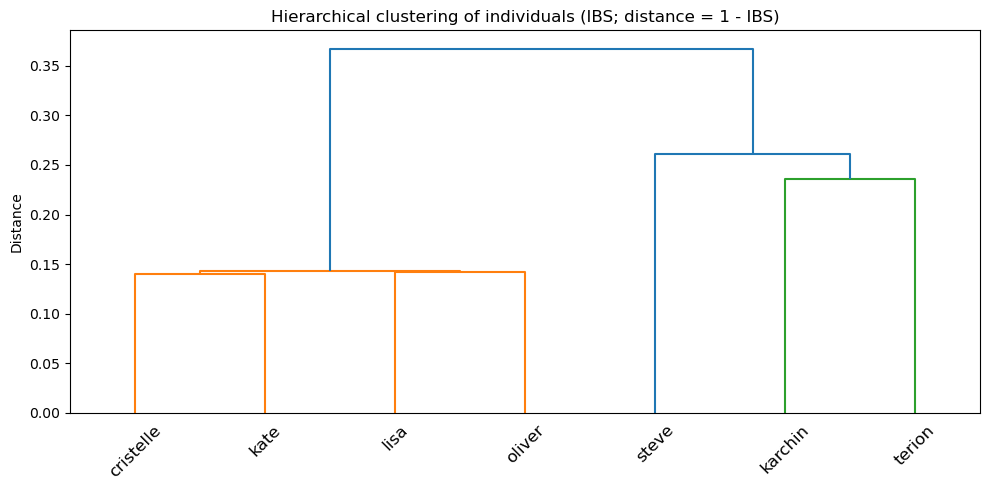

In [132]:
names = ibs_mat.index.tolist()

plt.figure(figsize=(10, 5))
dendrogram(Z, labels=names, leaf_rotation=45)
plt.title("Hierarchical clustering of individuals (IBS; distance = 1 - IBS)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()